# Sentence data exploration

Now that we have the text data split into sentences, let's load them up and take a quick look at what we have.

## Notebook setup

In [1]:
# Change working directory to parent so we can import as we would
# from the perplexity ratio score root directory
%cd ..

# PyPI imports
import pandas as pd

# Internal imports
import configuration as config
import notebooks.helper_functions.plotting_functions as plot_funcs

/home/siderealyear/projects/llm_detector/perplexity_ratio_score


## 1. Data loading

In [2]:
data_file=f'{config.INTERMEDIATE_DATA_PATH}/all_sentences.json'
data_df=pd.read_json(data_file)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66421891 entries, 0 to 66421890
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   text       object
 1   synthetic  int64 
 2   author     object
 3   source     object
dtypes: int64(1), object(3)
memory usage: 2.0+ GB


In [3]:
data_df.head()

,text,synthetic,author,source
0,She feels intellectually and emotionally stifl...,1,unknown_model,grinberg
1,Once you've made your decision and know exactl...,1,unknown_model,yatsenko
2,Web.,0,human,grinberg
3,Donaire earned a title in his 5th division by ...,0,human,yatsenko
4,A project manager will therefore determine to ...,0,human,grinberg


## 2. Data composition

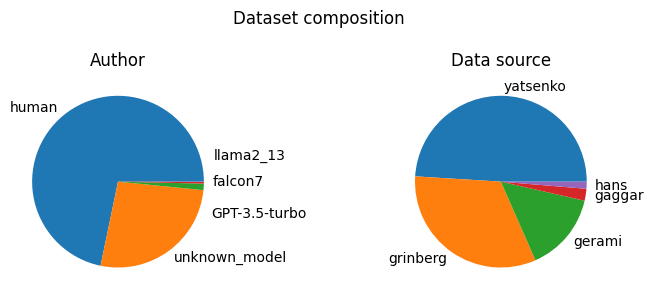

In [4]:
plot_obj=plot_funcs.data_composition(data_df)
plot_obj.savefig(f'{config.PLOT_PATH}/04-2_data_composition.jpg')
plot_obj.show()

## 3. Text length

In [5]:
data_df['words']=data_df['text'].apply(lambda x: len(x.split(' ')))
data_df['words'].describe()

count    6.642189e+07
mean     1.836516e+01
std      4.467347e+01
min      1.000000e+00
25%      1.000000e+01
50%      1.600000e+01
75%      2.400000e+01
max      7.009800e+04
Name: words, dtype: float64

### 3.1. Length distributions: all text

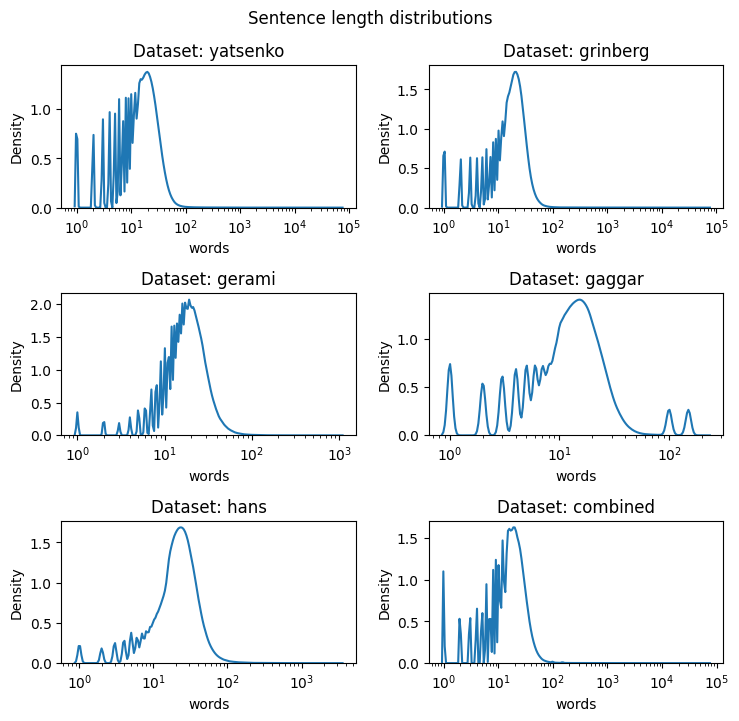

In [6]:
plot_obj=plot_funcs.length_distributions('Sentence length distributions', data_df)
plot_obj.savefig(f'{config.PLOT_PATH}/04-3.1_sentence_length_distributions.jpg')
plot_obj.show()

OK, cool - love how you can see quantization at short sentence lengths. It reminds me of polysomes on a sucrose gradient! Peak for each data source is around 20 words, effective max is about 100 or so words with some very long sentences - out to tens of thousands of words? That has to be junk. We also have a pretty large peak of single word sentences. Let's take a look at some examples of both.

### 3.2. Very long sentences

In [7]:
very_long_records=data_df[data_df['words'] > 200]
very_long_records['words'].describe()

count    48901.000000
mean       783.980225
std       1386.509091
min        201.000000
25%        275.000000
50%        420.000000
75%        764.000000
max      70098.000000
Name: words, dtype: float64

About 1.5% of records are longer than 100 words, less than a tenth of a percent are longer than 200 words. Let's take a look a few.

In [8]:
print(very_long_records['text'].iloc[0][:500])

Article reviewed                                                                                                                                                                                                                                                    
1            Watkins, A. M., Huebner, B. M., & Decker, S. H. (2008).


Ok, probably don't want this.

In [9]:
print(very_long_records['text'].iloc[1][:500])

Automobile Companies  US Market share of hybrid cars
Toyota Prius          39%                           
Honda Civic Hybrid    55%                           
Honda Insite          3%                            
GM                    2%                            
DiamierChrysier       1%                            


Table 1: Comparison among environmental friendly car shares in the US market.


This one sounds like machine word salad.

In [10]:
print(very_long_records['text'].iloc[2][:500])

Ask children to deliberate on visionary representation and explain why sight is an important sense;                                                                                                                                                                                                                                                                                                                                                                                                                 


More tabular stuff. I think we could cut sentences off at 200 words without loosing much.

### 3.3. Very short sentences

In [11]:
very_short_records=data_df[data_df['words'] <= 5]
very_short_records['words'].describe()

count    8.592231e+06
mean     2.915418e+00
std      1.470170e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: words, dtype: float64

Wow, lots of sentences shorter than 5 words. 8.6 million sentences is more than 10% of the data set. Let's see what a few looks like.

In [12]:
print(very_short_records['text'].iloc[0])

Web.


OK - garbage. Try a few more:

In [13]:
for i in range(1,10):
    print(f"\n{very_short_records['text'].iloc[i]}")


10268997), Web.

He smiled, laughing softly.

Hayhoe, Katharine.

I was a woman now.

Wait, wait, wait.

&lt;3 You're too sweet &lt;3

Clarity.

Retrieved from https://www.youtube.com/watch?v=ssuiqtreiBg&feature=related

Baghban, Z.

Her vision blackened.


Yep - also garbage.

In [14]:
for i in range(40,50):
    print(f"\n{very_short_records['text'].iloc[i]}")


–Willow " Cozy nosy! "

89-97.

(2009).

``Hey!

Since

Burlington: Elsevier Ltd., 2008.

Web.

(2012).

Web.

Karma's a bitch.....


Yep, also garbage. Some of this is probably down to bad splits. The rest looks like just junk. I'm reluctant to set arbitrary length thresholds. Kinda feeling like maybe we should perplexity score the whole thing and think more about it after. That way we can more easily experiment with different length thresholds. If we trim now and then score, if we decide we want to change the thresholds later, we have to go back and re-score at least some data.

Just for fun, let's take a look at the sentence length distributions for human vs machine text. But before we do - let's provisionally get rid of any single word sentences - we can pretty clearly justify that as a splitting failure, if nothing else. And for plotting's sake, let's cut at 200 words too.

### 3.4. Text length: human vs machine

In [15]:
# Length threshold the data
working_data_df=data_df[data_df['words'] > 1]
working_data_df=working_data_df[working_data_df['words'] < 100]

# Replace int values for 'synthetic' with human readable strings
working_data_df['synthetic']=working_data_df['synthetic'].map({0: 'human', 1: 'synthetic'})
working_data_df.head()

,text,synthetic,author,source,words
0,She feels intellectually and emotionally stifl...,synthetic,unknown_model,grinberg,25
1,Once you've made your decision and know exactl...,synthetic,unknown_model,yatsenko,30
3,Donaire earned a title in his 5th division by ...,human,human,yatsenko,23
4,A project manager will therefore determine to ...,human,human,grinberg,16
5,“Challenge and Response: Religious Life in Mel...,human,human,grinberg,14


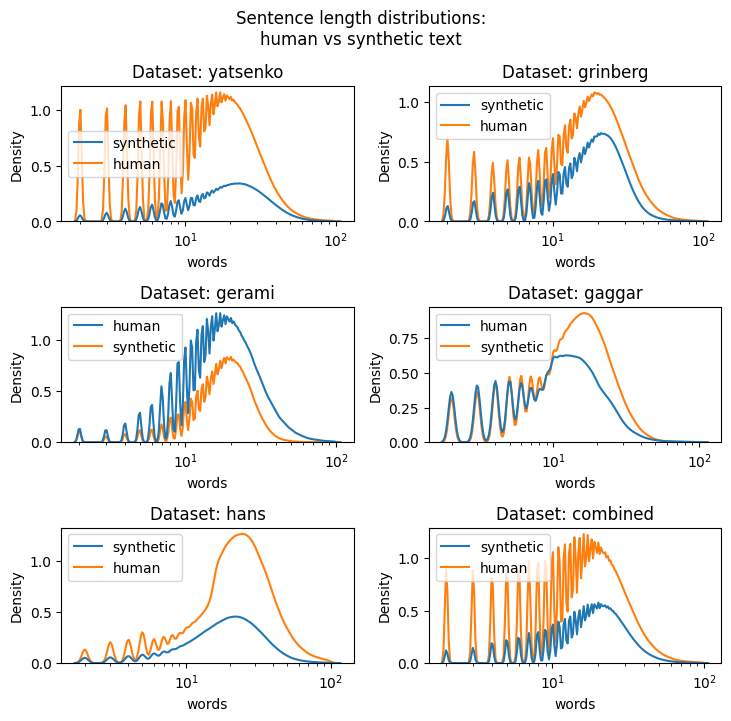

In [16]:
plot_obj=plot_funcs.length_distributions(
    'Sentence length distributions:\nhuman vs synthetic text',
    working_data_df, 
    hue_by='synthetic'
)

plot_obj.savefig(f'{config.PLOT_PATH}/04-3.4_human_vs_synthetic_length_distributions.jpg')
plot_obj.show()

OK - I see differences. Let's try plotting the histogram bin fractions against each other for synthetic and human text.

### 3.5. Length bin density: human vs synthetic

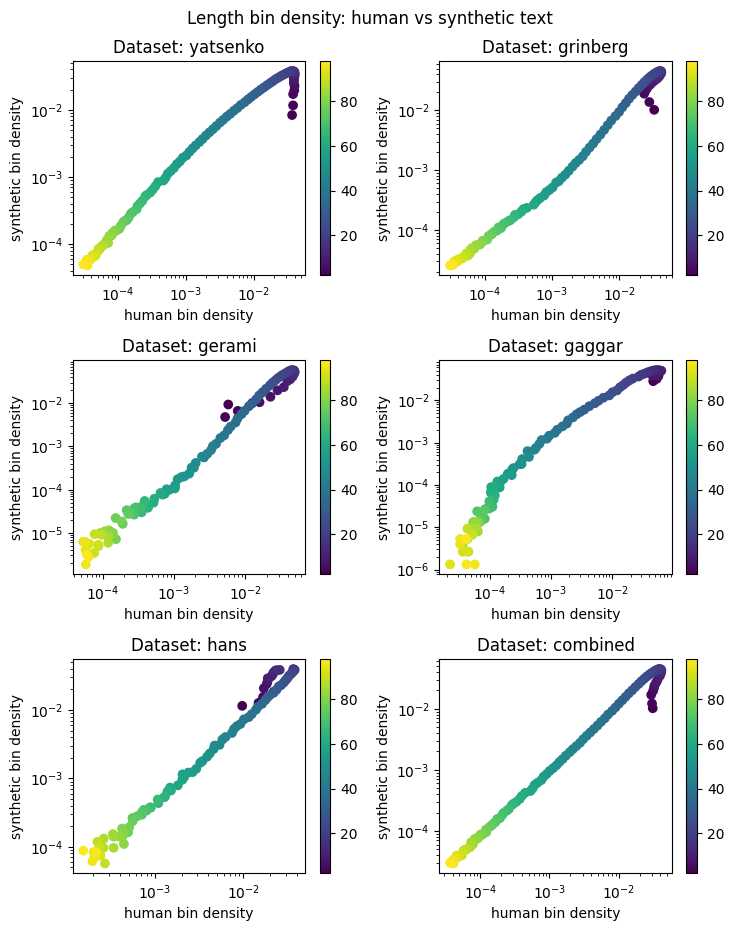

In [17]:
plot_obj=plot_funcs.bin_density_scatter(
    'Length bin density: human vs synthetic text',
    working_data_df
)

plot_obj.savefig(f'{config.PLOT_PATH}/04-3.5_human_vs_synthetic_length_bin_density_scatter.jpg')
plot_obj.show()

Clearly some differences in the distribution of sentences lengths between human and synthetic data sets. For longer sentences, the curves are almost linear, indicating that the human and synthetic data sets have similar length distributions. But for shorter sentences, the distributions diverge. For some data sources, the synthetic data tends to have more, shorter sentences (points above the x=y line). While for other data sources, the human tends to have more, shorter sentences (points below the x=y line). Overall, the tendency for human text to have more, shorter sentences dominates.

Not entirely sure what to do with this information - but it is interesting to know that there is a clear length dependent difference in the sentence length distributions.

## 4. Conclusion

We now have a good, sentence level data set to work with. It could probably use some character level clean-up and length thresholding, but is basically ready for perplexity ratio scoring as-is.

While thinking through tinkering with the sentence level data - I did have a realization. We can't really sample from it the way I had envisioned because doing so would result in random collections of sentences and not be representative of real machine or human generated text. This has a few implications:

1. We could use the sentence dataset as the training data as-is (with some additional clean-up)
2. We could use the text dataset as the training data and sample as before and accept the fact that sampled text will be broken arbitrarily. In this case, we will also need some clean-up strategies.
3. We could use a semantic splitter on the text data to generate chunks of text of an approximate size with more rational split boundaries.

I think we need to do some reading about text clean-up strategies. Let's also put the semantic splitting in motion.